In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,165.652621,8.718559,15.076980,19
IW Migration,251.597985,50.319597,69.119918,5
RAG Project,571.008410,35.688026,47.616117,16
Todd Ideas,638.895083,106.482514,246.894389,6
Azure AD Authentication,793.481749,61.037058,113.582703,13
Azure Functions + Visual Studio,1005.662273,77.358636,282.956091,13
Email Auth and Security,1033.161474,86.096789,204.266763,12
Azure DevOps Pipelines,1094.925869,42.112533,106.358414,26
Open Source/GitHub,1148.248479,71.765530,182.404325,16
Audit Report Tracker (Sharepoint List),1270.650575,105.887548,373.547566,12


# Histogram

sum of ages: ~46254.94


<Axes: >

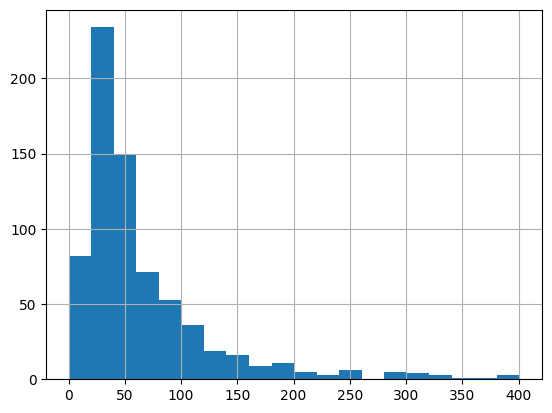

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [14]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 712
Total card age: 46254.94


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,IW Migration,Locking and Concurrency Control (SQL Server)\n...,bff97dc4943dd88730fe8f10f0d190ab,69.119918,50.319597,69.119918,251.597985,0.032000,5,0,0,-69.119918
1,IW Migration,Database Backup and Restore (SSMS)\nBuilt-in w...,083bd09675725caa49480be3eede358f,56.842289,50.319597,69.119918,251.597985,0.032000,5,1,0,-56.842289
2,IW Migration,Indexing (Access/SQL Server)\nA strategy for i...,5fdf5297e446f6ea2d26a3cc3c1cffd8,56.637056,50.319597,69.119918,251.597985,0.032000,5,2,0,-56.637056
3,IW Migration,VBA Modules (Access)\nVisual Basic for Applica...,ee6efc2896d6f87df85bd5db7971745b,46.612589,50.319597,69.119918,251.597985,0.032000,5,3,0,-46.612589
4,IW Migration,SSIS (SQL Server Integration Services)\nA plat...,41fd22d4bc7a949faf95cdd9305d1d92,22.386134,50.319597,69.119918,251.597985,0.032000,5,4,0,-22.386134
5,Todd Ideas,"In Azure AI Document Intelligence, Prebuilt mo...",9832d1cb76d86b95eed57284b992ed8f,246.894389,106.482514,246.894389,638.895083,0.663198,6,0,0,-246.894389
6,Todd Ideas,"In Azure AI Document Intelligence, Prebuilt mo...",53c699c062d669ddd5ba98d54ad468d0,156.007002,106.482514,246.894389,638.895083,0.663198,6,1,0,-156.007002
7,Todd Ideas,"In Azure AI Document Intelligence, The results...",81c5a16ccf56aee2942d3a919a07b581,80.694748,106.482514,246.894389,638.895083,0.663198,6,2,0,-80.694748
8,Todd Ideas,"In Azure AI Document Intelligence, document an...",935798db6bcd524d7034621caf8b31cc,72.873412,106.482514,246.894389,638.895083,0.663198,6,3,0,-72.873412
9,Todd Ideas,"In Azure AI Document Intelligence, the service...",e9f2f2eaf4cf59655b56fc627c2d57ca,47.409334,106.482514,246.894389,638.895083,0.663198,6,4,0,-47.409334



## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
683,Azure Developer Associate,Which Azure Cosmos DB consistency level maximi...,324d4923f4ef46338fe659ea5cd873b2,0.055011,42.615264,297.679951,4176.295828,0.268011,98,97,9,-0.055011
693,Azure Developer Associate,How can you group keys in Azure App Configurat...,841cf130fcef72dbef5c554ba7e48011,0.181206,42.615264,297.679951,4176.295828,0.268011,98,96,9,-0.181206
675,Azure Developer Associate,What Azure CLI command allows CORS from https:...,95d2a75240a646635b69d89fe62896ef,0.215640,42.615264,297.679951,4176.295828,0.268011,98,95,9,-0.215640
689,Azure Developer Associate,Where do you associate a stored access policy ...,902bb129e8b619f0bbcf5a9a924c2230,0.236210,42.615264,297.679951,4176.295828,0.268011,98,94,9,-0.236210
691,Azure Developer Associate,Which role is required to generate a user dele...,4cd23bedbb8767d0fa5ef3af1af19dc8,0.321864,42.615264,297.679951,4176.295828,0.268011,98,93,9,-0.321864
697,Azure Developer Associate,Which persistence setting minimizes storage co...,80195742cf378c711ab51bf4d8523fb0,0.427496,42.615264,297.679951,4176.295828,0.268011,98,92,9,-0.427496
687,Azure Developer Associate,How do you temporarily prevent modifications o...,21117713fff05e435e78a6d087294d21,0.467872,42.615264,297.679951,4176.295828,0.268011,98,91,9,-0.467872
694,Azure Developer Associate,Which CLI command rotates a key in Azure Key V...,a51b2d0b754e4678ad97c60f8ed159e8,0.659905,42.615264,297.679951,4176.295828,0.268011,98,90,9,-0.659905
682,Azure Developer Associate,Which CLI command deploys an Azure Container A...,8e4dbb0f18787d0869708060d58a81c4,0.670914,42.615264,297.679951,4176.295828,0.268011,98,89,8,-0.670914
705,Azure Developer Associate,"How do you expose only necessary operations, s...",5de0802db75f5a5af26e567cddae4eef,0.747192,42.615264,297.679951,4176.295828,0.268011,98,88,8,-0.747192


In [18]:
existing_cards.head(10).sum()

head                   IW MigrationIW MigrationIW MigrationIW Migrati...
body                   Locking and Concurrency Control (SQL Server)\n...
hash                   bff97dc4943dd88730fe8f10f0d190ab083bd09675725c...
age                                                           855.476871
subject_mean_age                                              784.010554
subject_highest_age                                          1580.071534
subject_age_sum                                               4452.46534
head_random_roll                                                3.475992
frequency                                                             55
count                                                                 20
n_fold                                                                 0
neg_age                                                      -855.476871
dtype: object

In [19]:
existing_cards['age'].mean()

64.96480072504973